## Train models

### Asif Hamid bhat 

code originally created by Yuying Liu,
This script is a template for training various models.

In [1]:
### clear ram
# import torch
# with torch.no_grad():
#     torch.cuda.empty_cache()
# %reset

In [1]:
import os
import matplotlib.pyplot as plt
import sys
import torch
import numpy as np
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path) 
from Autoencoder import *
from utils import *
import ResNet as net
# import lstmrnn

In [2]:
# adjustables
k = list(range(11))            # model index: should be in {0, 2, ..., 10}
dt = 0.01  # time unit: 0.0005 for Lorenz and 0.01 for others
model_prefix='KS'
system = 'KS'         # system name: ""FHN","KS,'RD'
noise = 0.0                    #noise levels: 0.0, 0.01, 0.02, 0.05 ,0.1, 0.2
hidden_size=10
lr = 1e-3                     # learning rate
max_epoch = 10000            # the maximum training epoch
            # training batch size
# arch = [200, 128, 64,4, 128,64, 200]  # architecture of the neural network (check paper for details)

In [3]:
# paths
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path_to_result=os.path.join('../results/', system)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# global const
n_forward = 5

### LOAD DATA

### LOAD DATA

In [4]:
train_data = torch.load(data_dir + "/train_data.pt")
val_data = torch.load(data_dir + "/val_data.pt")
test_data = torch.load(data_dir + "/test_data.pt")
train_data=train_data[:10,:,:]
# val_data=val_data[:,:-1,:]

# test_data=test_data[:,:-1,:]
T1=train_data.shape[1]-1
T2=2*T1
T3=3*T1
T5=5*T1
T7=7*T1
T10=10*T1
n=train_data.shape[2]

In [5]:
train_data=train_data[:10,:,:]

In [6]:
train_data.shape,val_data.shape,test_data.shape

(torch.Size([10, 5121, 120]),
 torch.Size([5, 5121, 120]),
 torch.Size([5, 5121, 120]))

In [7]:
# test_data = torch.load(data_dir + "/test_data.pt")

In [8]:
# load data
# train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
# val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
# n_val = val_data.shape[0]
# n_test = test_data.shape[0]
batch_size = n_train 

In [9]:
train_data=torch.tensor(train_data)
train_data = train_data.to(torch.float32).to(device)
sets=train_data.shape[0]
dataloader=torch.utils.data.DataLoader(train_data, batch_size=32) ### 32 for FHN 

#### Train autoencoder

In [10]:
# input_size

In [11]:
model_dir

'../models/KS'

In [12]:
# define model and train
######Define the autoencoder class
input_size=train_data.shape[2]
L1=120  ### 100,100,100 for fhn and 120,120,100 for KS
L2=120
L3=100
modelAE = AE(L1,L2,L3,input_size, hidden_size).to(device)
num_epochs = 5000 # 5,000 for FHN,KS
learning_rate = 1e-3
aemodel='/AE_{}.pt'.format(hidden_size)
save_path=model_dir+aemodel
train(modelAE, dataloader, num_epochs=num_epochs, learning_rate=1e-3,model_path=save_path)
###modelAE.train(dataloader=dataloader, num_epochs=num_epochs, learning_rate=learning_rate)
# torch.save(modelAE.state_dict(), '../models/FHN/AE_{}.pt'.format(hidden_size))

Epoch [1000/5000], Loss:3.34468368e-03
(--> new model saved @ epoch 1000)
Epoch [2000/5000], Loss:1.55382394e-03
(--> new model saved @ epoch 2000)
Epoch [3000/5000], Loss:2.60697072e-03
Epoch [4000/5000], Loss:8.88397277e-04
(--> new model saved @ epoch 4000)
Epoch [5000/5000], Loss:7.70210230e-04
(--> new model saved @ epoch 5000)


In [13]:
# model_dir,device

In [14]:
### original
# define model and train
# #####Define the autoencoder class
# import time
# input_size=train_data.shape[2]
# hidden_size=2
# L11=100
# L2=100
# L3=100
# epochs = 5000
# modelAE = AE(L11,L2,L3,input_size, hidden_size).to(device)
# save_path=model_dir+'/FHNAE_best.pt'
# save_path=model_dir+'/KStest.pt'
# start_ae=time.time()
# train(modelAE, dataloader, num_epochs=epochs, learning_rate=1e-3,model_path=save_path)
# end_ae=time.time()
# ae_cputime=end_ae-start_ae
# print('done!')
# print(ae_cputime)
# trainAE(modelAE,dataloader, num_epochs, learning_rate=1e-4)
# torch.save(modelAE.state_dict(), '../models/KS/AE2_{}_{}.pt'.format(hidden_size,n_train))

In [15]:
####Load FHN AE BEST models
modelAE.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [16]:
# model_path='../models/FHN/AE_{}_{}.pt'.format(hidden_size,n_train) ###for fhn
# model_path='../models/KS/AE2_{}_{}.pt'.format(hidden_size,n_train)
# model_state_dict = torch.load(model_path)
# modelAE.load_state_dict(model_state_dict)

In [17]:
#Data for latent dimension
z_train=modelAE.encoder(train_data)
z_valid=modelAE.encoder(torch.tensor(val_data[:,:T1+1,:]).to(torch.float32).to(device))
z_test=modelAE.encoder(torch.tensor(test_data[:,:T1+1,:]).to(torch.float32).to(device))
z_train.shape,z_valid.shape,z_test.shape

(torch.Size([10, 5121, 10]),
 torch.Size([5, 5121, 10]),
 torch.Size([5, 5121, 10]))

In [18]:
# data.shape

#### Set wise training HIts

In [19]:
z_train1=z_train

In [20]:
z_train1.shape

torch.Size([10, 5121, 10])

In [21]:
data=z_train1#.reshape(z_train1.shape[0]*z_train1.shape[1],z_train1.shape[2])
data=data.cpu().detach().numpy()
data.shape

(10, 5121, 10)

In [22]:
# n_steps= data.shape[1] - 1
# resdata = np.empty((0, step_size * n_forward + 1, data.shape[2]))
# for step_size in step_sizes:
#     for j in range(10):
#         data=z_train1[j,:,:].cpu().detach().numpy()
#         m = int(np.ceil(n_steps/(step_size*n_forward)))
#         pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
#         print(pdata.shape)
#         for i in range(m):
#             start_idx = i*step_size*n_forward
#             end_idx = start_idx + step_size*n_forward + 1
#             tmp = data[start_idx:end_idx, :]
#             pdata[i, :tmp.shape[0], :] = tmp
#         resdata = np.concatenate((resdata, pdata), axis=0)

In [23]:
sets

10

In [24]:
n_steps = data.shape[1] - 1
n_steps

5120

In [25]:
z_train1.shape

torch.Size([10, 5121, 10])

In [26]:
### one set training 
# dummy parameter
data=z_train1[:10,:,:]#.reshape(z_train1.shape[0]*z_train1.shape[1],z_train1.shape[2])
sets=z_train1.shape[0]
data=data.cpu().detach().numpy()
models = list()
L1=128
L2=256
L3=512
L4=1024
L5=2048
z=hidden_size
#[z,L1,L2,L3,L4,L5,L4,L3,L2,L1,z]
dt = 1  
n_forward=5
# step_sizes=[256]
# step_sizes=[1,6,36,216,1296]
step_sizes=[1,2,4,8,16,32,64,128,256,512,1024]
# step_sizes=[16,32,64,128,256,512,1024]
# step_sizes=[1]
# training
max_epoch=20000
start=time.time()
n_steps = data.shape[1] - 1  # number of forward steps
for step_size in step_sizes:
    resdata = np.empty((0, step_size * n_forward + 1, z_train1.shape[2]))
    for j in range(sets):
        data=z_train1[j,:,:].cpu().detach().numpy()
        m = int(np.ceil(n_steps/(step_size*n_forward)))
        pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
        for i in range(m):
            start_idx = i*step_size*n_forward
            end_idx = start_idx + step_size*n_forward + 1
            tmp = data[start_idx:end_idx, :]
            pdata[i, :tmp.shape[0], :] = tmp
        resdata = np.concatenate((resdata, pdata), axis=0)
    pdata=resdata
    dataset = net.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
    model_name = 'modelKS_D{}_h{}.pt'.format(step_size,hidden_size)
    print('MODEL: '+model_prefix+'_D{}_h{}'.format(step_size,hidden_size))
    model = net.ResNet(arch=[z,L4,L4,L4,z], dt=dt, step_size=step_size)
    model.train_net(dataset, max_epoch=max_epoch, batch_size=32, lr=1e-3, model_path=os.path.join(model_dir, model_name))
    models.append(model)
end=time.time()
train_time=end-start
print(train_time)
print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

MODEL: KS_D1_h10
epoch 1000, training loss 0.0007058691699057817, validation loss 0.0008411856251768768
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.0004134595219511539, validation loss 0.0004330627270974219
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.0004702173755504191, validation loss 0.00040564732626080513
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.00032227145857177675, validation loss 0.0003826737229246646
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.0003899821313098073, validation loss 0.00038749989471398294
epoch 6000, training loss 0.0002578617713879794, validation loss 0.0003761422703973949
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.0003352499916218221, validation loss 0.0003616265021264553
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.00034778594272211194, validation loss 0.00035482741077430546
(--> new model saved @ epoch 8000)
epoch 9000, training loss 0.000398415

In [27]:
#### one set training 
# # dummy parameter
# batch_size=40
# models = list()
# L1=128
# L2=256
# L3=512
# L4=1024
# L5=2048
# z=hidden_size
# #[z,L1,L2,L3,L4,L5,L4,L3,L2,L1,z]
# dt = 1  
# n_forward=5
# step_sizes=[16]
# # step_sizes=[1,6,36,216,1296]
# # training
# max_epoch=20000
# model_prefix='KS'
# n_steps = data.shape[0] - 1  # number of forward steps
# for step_size in step_sizes:
#     m = int(np.ceil(n_steps/(step_size*n_forward)))
#     pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
#     print(pdata.shape)
#     for i in range(m):
#         start_idx = i*step_size*n_forward
#         end_idx = start_idx + step_size*n_forward + 1
#         tmp = data[start_idx:end_idx, :]
#         pdata[i, :tmp.shape[0], :] = tmp
#     dataset = net.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
#     model_name = 'model_D{}_noise{}.pt'.format(step_size,noise)
#     print('MODEL: '+model_prefix+'_D{}'.format(step_size))
#     model = net.ResNet(arch=[z,L4,L4,L4,z], dt=dt, step_size=step_size)
#     model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr, model_path=os.path.join(model_dir, model_name))
#     models.append(model)

# print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [28]:
#### Normalize data

In [29]:
# from torch.nn.functional import normalize
# data_scaled = normalize(z_train)
# data_scaled_val = normalize(z_valid)

In [30]:
# plt.plot(data_scaled[0,:,0].cpu().detach().numpy(),data_scaled[0,:,1].cpu().detach().numpy(),label='data_scaled')
# # plt.plot(z_train[0,:,0].cpu().detach().numpy(),'--')
# plt.show()

In [31]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(z_train.cpu().detach().numpy())
# data_scaled = scaler.transform(z_train)

#### Hits training

In [32]:
tspan=z_train.shape[1]#### Hits training]
np.random.seed(2)  # for reproduction
dt = 0.01  #0.001
train_steps = tspan  # at least equal to the largest step size
val_steps =tspan
test_steps = tspan  # t=20
t = np.linspace(0, (train_steps-1)*dt, train_steps)

In [58]:
#a=np.array([1,8,64,128,256,512,1024,2048,10240,20480,40960])
# load the data to dataset object
dt=0.01
datasets = list()
step_sizes = list()
print('Dt\'s: ')
#a=[10,20,30,60,100,200,400,600,800]
for i in range(11):
    step_size = 2**i  #exponential function
    print(step_size)
    print(step_size * dt)
    step_sizes.append(step_size)
    datasets.append(DataSet(z_train, z_valid, z_test, dt, step_size=step_size, n_forward=5))

Dt's: 
1
0.01
2
0.02
4
0.04
8
0.08
16
0.16
32
0.32
64
0.64
128
1.28
256
2.56
512
5.12
1024
10.24


In [54]:
# step_sizes=step_sizes[3:]
# step_sizes

In [24]:
### For 16 model arch=[n,L1,L1,L1,n]

In [27]:
model_dir

'../models/FHN'

In [29]:
# ### FOR FHN DATA
models = list()
max_epoch=20000
L1=128
L2=256
L3=512
L4=1024
L5=2048
z=hidden_size
# archs=[[z,L4,L4,L4,z],[z,L5,L5,L5,z],[z,L5,L5,L5,L5,L5,L5,L5,z],[z,L5,L5,L5,z],[z,L4,L4,L4,L4,L4,L4,L4,z],[z,L4,L4,L4,L4,L4,z],[z,L3,L3,L3,L3,L3,z],
#        [z,L5,L5,L5,L5,L5,L5,L5,z],[z,L5,L5,L5,L5,z],[z,L3,L3,L3,L3,z],[z,L2,L2,L2,L2,L2,z]]
start_time1 = time.time()
for (step_size, dataset) in zip(step_sizes, datasets):
    # set up the network
    model_name = 'modelFHN_D{}.pt'.format(step_size)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelresnet = net.ResNet(arch=[z,L1,L1,L1,L1,L1,L1,z], dt=dt, step_size=step_size)
    # training
    print('training model_D{} ...'.format(step_size))
    modelresnet.train_net(dataset, max_epoch=max_epoch, batch_size=n_train, lr=1e-3, model_path=os.path.join(model_dir, model_name))
    models.append(modelresnet)
end_time1 = time.time()
offline_time=end_time1-start_time1
print('offline time elaspsed is',offline_time)
print('models trained successfully!')

training model_D1 ...
epoch 1000, training loss 3.510562919473159e-06, validation loss 0.0010738716227933764
(--> new model saved @ epoch 1000)
epoch 2000, training loss 3.309609155621729e-06, validation loss 0.0013500157510861754
epoch 3000, training loss 4.497781901591225e-06, validation loss 0.002472593681886792
epoch 4000, training loss 1.5336139540522709e-06, validation loss 0.004499186761677265
epoch 5000, training loss 6.530447080876911e-07, validation loss 0.00952882505953312
epoch 6000, training loss 1.0102753549290355e-06, validation loss 0.010454739443957806
epoch 7000, training loss 4.1239982238039374e-06, validation loss 6.369817856466398e-05
(--> new model saved @ epoch 7000)
epoch 8000, training loss 6.902208497194806e-06, validation loss 0.0002865973801817745
epoch 9000, training loss 5.148032414581394e-06, validation loss 0.0003528624074533582
epoch 10000, training loss 2.025097273872234e-06, validation loss 0.0004305729817133397
epoch 11000, training loss 5.0374876536

In [48]:
## load RN models
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}.pt'.format(step_size))
#     models.append(torch.load(os.path.join(model_dir, 'modelnew_D{}_noise{}.pt'.format(step_size,noise))))
# model_name = 'model_D{}_noise{}.pt'.format(step_size,noise)
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}.pt'.format(step_size,noise)))) ### Best result so far
noise=0.0
models = list()
for step_size in step_sizes:
    print('loading model_D{}.pt'.format(step_size,))
    models.append(torch.load(os.path.join(model_dir, 'modelFHN_D{}.pt'.format(step_size)))) 

loading model_D1.pt
loading model_D2.pt
loading model_D4.pt
loading model_D8.pt
loading model_D16.pt
loading model_D32.pt
loading model_D64.pt
loading model_D128.pt
loading model_D256.pt
loading model_D512.pt
loading model_D1024.pt


In [18]:
# noise=0.0
# models = list()
# for step_size in step_sizes:
#     print('loading model_D{}_h{}.pt'.format(step_size,hidden_size))
#     models.append(torch.load(os.path.join(model_dir, 'model_D{}_h{}_noise{}.pt'.format(step_size, hidden_size,noise))))

In [ ]:
print('# of params of RNN models: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

In [25]:
# import pickle
# with open("test", "rb") as fp:
#     val_matrices = pickle.load(fp)

#### LSTM TRAINING

In [16]:
data=z_train
data.shape[-1]
lstmmodel = lstmrnn.LSTMWrapper(data.shape[-1], 425).to(device) ### 425 for FHN,
print('# of params: ', sum(p.numel() for p in lstmmodel.parameters() if p.requires_grad))

# of params:  730152


In [17]:
#print('# of params: ', sum(p.numel() for p in lstmmodel.parameters() if p.requires_grad))

In [18]:
z_train.shape

torch.Size([4, 5121, 2])

In [ ]:
# choose the hidden size so that # of parameters match 
# data=z_train
# lstmmodel = lstmrnn.LSTMWrapper(data.shape[-1], 10).to(device)
# print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

# training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstmmodel.parameters(), lr=lr)
max_epoch=20000
epoch = 0
best_loss = 1e+5
import time
lstm_start=time.time()
while epoch < max_epoch:
    epoch += 1
    preds = lstmmodel(torch.tensor(data[:, :-1, :]).float()).to(device)
    loss = criterion(preds, torch.tensor(data[:, 1:, :]).float())
    if best_loss <= 1e-10:
        print('--> model has reached an accuracy of 1e-10! Finished training!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}, training loss {}'.format(epoch, loss.item()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print('(--> new model saved @ epoch {})'.format(epoch))
            torch.save(lstmmodel, os.path.join(model_dir,'lstm_model.pt'))
lstm_end=time.time()
lstm_traintime=lstm_end-lstm_start
print(lstm_traintime)

epoch 1000, training loss 0.0014195143012329936
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.0009523196495138109
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.00062045908998698
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.0004012904246337712
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.00023397379845846444
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.00020922468684148043
(--> new model saved @ epoch 6000)
epoch 7000, training loss 4.433157664607279e-05
(--> new model saved @ epoch 7000)
epoch 8000, training loss 2.2439289750764146e-05
(--> new model saved @ epoch 8000)
epoch 9000, training loss 2.3523200070485473e-05
epoch 10000, training loss 1.3013115676585585e-05
(--> new model saved @ epoch 10000)
epoch 11000, training loss 5.74259101995267e-05
epoch 12000, training loss 1.184995380754117e-05
(--> new model saved @ epoch 12000)
epoch 13000, training loss 1.0122110325028189e-05
(--> new model sa

In [22]:
print(lstm_traintime)

3136.293374300003


In [13]:
# z_test1=z_test[:,:T1,:]
# lstmmodel = torch.load(os.path.join(model_dir,'lstm_model.pt'))
# y_init = torch.tensor(z_test1[:, [0], :]).float()
# y_lstm = lstmmodel(y_init, t=z_test1.shape[1])

#y_preds = torch.cat([y_init, y_preds], dim=1).squeeze().detach().numpy()
# if normalize:
#     y_preds = y_preds * ranges + mean_values
#np.save(os.path.join(path_to_result,'lstm_model_pred.npy', y_lstm))

In [21]:
aa=0

#### reservoir computing

In [46]:
z_trainRC=z_train[:1,:,:]
data=z_trainRC.reshape(z_trainRC.shape[0]*z_trainRC.shape[1],z_trainRC.shape[2])
data=data.T
data.shape

torch.Size([8, 5121])

In [47]:
# no. of parameters=1548762 FHN,KS= 2346888

In [51]:
# choose the hidden size so that # of parameters match 
import esn
RCmodel = esn.ESN(data.shape[1], 450).to(device) ### 300_fhn,
RC_pred = RCmodel(torch.tensor(data[:-1, :]).float()).to(device)
truth = torch.tensor(data[1:, :]).float()
W_out = RC_pred.pinverse() @ truth
print('# of params: ', W_out.shape[0]*W_out.shape[1])

# of params:  2304450


In [53]:
# z_testRC.shape

In [54]:
idx=0
z_testRC=z_test[idx,:T1+1,:].T
RC_preds = torch.zeros(z_testRC.shape)
RC_preds[0, :] = torch.tensor(z_testRC[0, :]).float()
h_pred = RCmodel.f(RCmodel.W_in @torch.tensor(z_testRC[0, :]).float())
RC_pred = torch.matmul(h_pred, W_out)
RC_preds[1, :] = RC_pred
for t in range(2, z_testRC.shape[0]):
    h_pred = RCmodel.f(RCmodel.W_in @ RC_pred + RCmodel.W_hat @ h_pred)
    RC_pred = torch.matmul(h_pred, W_out)
    RC_preds[t, :] = RC_pred
    
RC_preds = RC_preds.detach().numpy()
RC_preds=RC_preds.T
# if normalize:
#     y_preds = y_preds * ranges + mean_values
torch.save(RC_preds, path_to_result + "/reservoir_pred.pt")
# np.save(os.path.join(path_to_result, 'reservoir_pred.npy', RC_preds))

In [ ]:
# z_testRC.shape[0]

### SINDY training

In [56]:
# pip install pysindy

In [57]:
import pysindy as ps

In [58]:
# Instantiate and fit the SINDy model
idx=0
dt=0.01
z_trainS=z_train[:100,:,:]
z_trainS=z_trainS.reshape(z_trainS.shape[0]*z_trainS.shape[1],z_trainS.shape[2]).cpu().detach().numpy()
sindymodel = ps.SINDy()
sindymodel.fit(z_trainS, t=dt)
sindymodel.print()

KeyboardInterrupt: 

In [ ]:
# Evolve the Lorenz equations in time using a different initial condition
n_steps_test=T1
t_test=np.linspace(0,(n_steps_test-1)*dt, n_steps_test)
#t_test = np.arange(0, 15, dt)
x0_test = z_test[idx,0,:].cpu().detach().numpy()
x_test=z_test[idx,:n_steps_test,:].cpu().detach().numpy()
# t_test_span = (t_test[0], t_test[-1])
# x_test = solve_ivp(lorenz, t_test_span, x0_test,
#                    t_eval=t_test, **integrator_keywords).y.T

# Compare SINDy-predicted derivatives with finite difference derivatives
#print('Model score: %f' % model.score(x_test, t=dt))

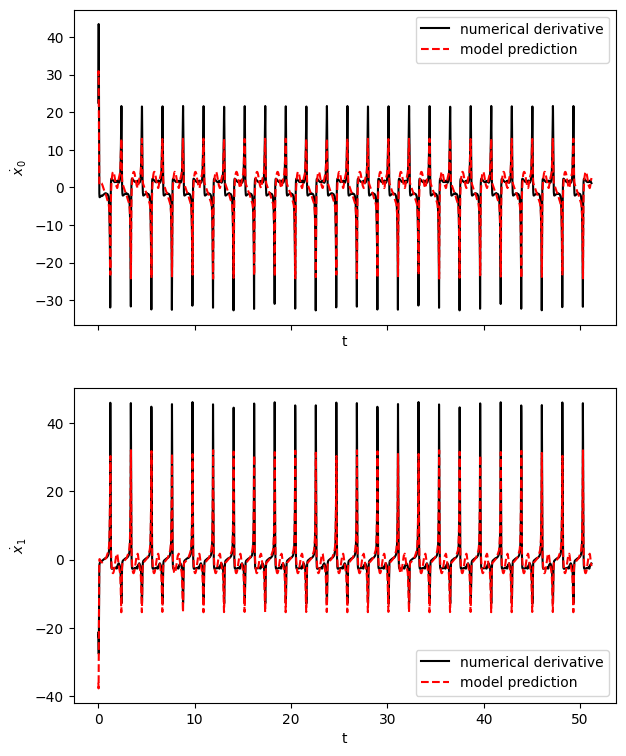

In [49]:
# Predict derivatives using the learned model
x_dot_test_predicted = sindymodel.predict(x_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = sindymodel.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

In [52]:
x0_test.shape,t_test.shape

((2,), (5120,))

In [ ]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = sindymodel.simulate(x0_test, t_test)

In [50]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = sindymodel.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1261646232166D+01   r2 =  0.9793960687473D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1261646232166D+01   r2 =  0.9793960687473D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1261646232166D+01   r2 =  0.9793960687473D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1261646232166D+01   r2 =  0.9793960687473D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
# # create dataset object
# datasets = list()
# step_sizes = list()
# step_size = [2**k for k in k]
# print('Dt\'s: ')
# for i in range(11):
#     step_size = 2**i
#     print(step_size * dt)
#     step_sizes.append(step_size)
#     datasets.append(net.DataSet(train_data, val_data, test_data, dt, step_size=step_size, n_forward=n_forward))

# dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

In [ ]:
# models=list()
# for (step_size, dataset) in zip(step_sizes, datasets):
#     print('training model_D{} ...'.format(step_size))
#     model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
#     #model object
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     #model = torch.load(os.path.join(model_dir, model_name), map_location=device)
#     #model.device = device
#     # set up the network
#     model = net.ResNet(arch=arch, dt=dt, step_size=step_size)
#     # training
#     model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,  model_path=os.path.join(model_dir, model_name))
#     models.append(model)

# print('models trained successfully!')
# # create/load model object
# # try:
# #     device = 'cuda' if torch.cuda.is_available() else 'cpu'
# #     model = torch.load(os.path.join(model_dir, model_name), map_location=device)
# #     model.device = device
# # except:
# #     print('create model {} ...'.format(model_name))
# #     model = net.ResNet(arch=arch, dt=dt, step_size=step_size)
# #
# # # training
# # model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
# #                 model_path=os.path.join(model_dir, model_name))